Before answering this question, see where you are in the data-processing workflow:

![Feature Engineering](assets/feature_engineering.png)

As the diagram above shows, with this checkpoint, you'll start to explore how to convert text data into numerical form. This is the feature-engineering step that you need to do before feeding your data into any machine-learning algorithm. Converting text into numerical form is often called *language modeling* in NLP jargon, and it's one of the most active research areas in NLP. This process is called language modeling because of semantics; a good numerical representation of the text should be able to capture the meaning of the words and their relationships between each other. You'll learn about semantics in the next checkpoint. For now, you'll just focus on a simple way to represent words in numerical form.

To accommodate the feature-generation techniques that you'll learn here and to see how they perform on a machine-learning task, you'll feed your new numerical features into some machine-learning algorithms. You'll also make some classifications to demonstrate the pros and cons of your feature-engineering methods. Hence, your first hands-on NLP application in this module will be *text classification*. 

Continue on to get started!

# Bag-of-words

The first feature-generation approach that you'll learn about here is called *bag-of-words* (BoW). BoW is quite simple: your goal is to create a feature matrix such that the rows are observations, and each column is a unique word in your vocabulary. You fill in this matrix by counting how many times each word appears in each observation. You then use those counts as features. 

As mentioned, BoW is simple and very easy to implement using libraries like scikit-learn. In the jargon of scikit-learn, generating BoW features is called `CountVectorizer`, as you'll see shortly. However, before moving on to implement the BoW approach, you'll need to do some data cleaning. 

Begin by importing the libraries that you'll be using:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import en_core_web_sm as spacy
import re
from nltk.corpus import gutenberg
import nltk
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")

#nltk.download('gutenberg')

Now, write a helper function called `text_cleaner` for cleaning the text. Specifically, remove some punctuation marks and numbers from the text:

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation that spaCy doesn't
    # recognize: the double dash '--'. Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text

Next, load Jane Austen's *Persuasion* and Lewis Carroll's *Alice's Adventures in Wonderland* from NLTK's Gutenberg module. In this checkpoint, you'll be working on these two texts, and your ultimate goal will be to distinguish the authors from their sentences. Hence, your unit of observation (your *documents*) will be the sentences of these novels.

After you load the novels, do some data cleaning. First, remove the chapter indicators from the novels. Then apply the `text_cleaner` function from above to clean up some punctuation marks and the numbers:

In [3]:
# Load and clean the data
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

The cleaned texts are stored in two variables called `alice` and `persuasion`. Note that you haven't split the texts into sentences yet. You'll do that using spaCy. For that purpose, load spaCy's English module and use spaCy to parse both the `alice` and `persuasion` texts:

In [4]:
# Parse the cleaned novels. This can take some time.
nlp = spacy.load()

alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

You can split your texts into sentences now. This process is easy using spaCy. Because you've already parsed your documents with spaCy, you can now use spaCy's functionalities. In this case, spaCy will take care of deriving the sentences from the texts. What you need to do is to iterate over the parsed documents after calling the `.sents` attribute. With the following code, you can iterate using list comprehension.

In [5]:
# Group into sentences
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one DataFrame
sentences = pd.DataFrame(alice_sents + persuasion_sents, columns = ["text", "author"])
sentences.head()

,text,author
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(Oh, dear, !)",Carroll


As a result, your dataset consists of two columns. The first column has the sentences, and the second column has the authors. Before jumping into BoW, you need to remove stop words and punctuation marks, and then convert your tokens to lemmas or stems. In this example, you'll lemmatize your tokens. Again, you'll make use of the attributes of the documents that spaCy parsed.

In [6]:
# Get rid of stop words and punctuation,
# and lemmatize the tokens
for i, sentence in enumerate(sentences["text"]):
    sentences.loc[i, "text"] = " ".join(
        [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop])

Now you can start converting the text in the first column of your dataset into a numerical form. As mentioned before, you'll use the BoW approach. For this purpose, use `CountVectorizer` from scikit-learn, as follows:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(sentences["text"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
sentences = pd.concat([bow_df, sentences[["text", "author"]]], axis=1)

And that's all! Now, check out your new dataset:

In [8]:
sentences.head()

,1st,29th,abbreviation,abdication,abide,ability,able,abode,abominable,abominate,...,younker,youth,youthful,zeal,zealand,zealous,zealously,zigzag,text,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Alice begin tired sit sister bank have twice p...,Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,consider mind hot day feel sleepy stupid pleas...,Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,remarkable Alice think way hear Rabbit,Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll


As you can see, you now have a dataset that matches the format that you're used to in this program. It's in tabular form: observations are the rows and features are the columns. More importantly, you converted text into a numerical form, so you can apply machine-learning algorithms using these as input. This enables you to move to the modeling phase, as indicated below.

![Modeling](assets/modeling.png)

## BoW in action

Now, give the bag-of-words features a whirl by trying some machine-learning algorithms:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

Y = sentences['author']
X = np.array(sentences.drop(['text','author'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
print(classification_report(y_test, lr.predict(X_test)))
print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
print(classification_report(y_test, rfc.predict(X_test)))
print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))
print(classification_report(y_test, gbc.predict(X_test)))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9354838709677419

Test set score: 0.8761651131824234
              precision    recall  f1-score   support

      Austen       0.86      0.97      0.91      1537
     Carroll       0.91      0.67      0.78       716

    accuracy                           0.88      2253
   macro avg       0.89      0.82      0.85      2253
weighted avg       0.88      0.88      0.87      2253

----------------------Random Forest Scores----------------------
Training set score: 0.9795797573246523

Test set score: 0.8530847758544163
              precision    recall  f1-score   support

      Austen       0.88      0.91      0.89      1537
     Carroll       0.79      0.74      0.76       716

    accuracy                           0.85      2253
   macro avg       0.83      0.82      0.83      2253
weighted avg       0.85      0.85      0.85      2253

----------------------Gradient Boosting Scores--------------

It looks like logistic regression and random forest overfit. Overfitting is a known problem when using the bag-of-words approach because it involves throwing a massive number of features at a model. Some of those features (in this case, word frequencies) will capture noise in the training set. Because overfitting is also a known problem with random forests, the divergence between training score and test score is expected. On the other hand, training and test scores from gradient boositng are close to each other.

# N-grams: words in context

Consider the word `vain` in these two sentences:

    “She labored in vain; the rock would not move.” 

    “She was so vain, her bathroom mirror was covered in lip prints.”

In both sentences, `vain` is an adjective. In the first sentence, it signals a lack of success. In the second sentence, the same word means vanity. Since the two usages can't be distinguished by their part of speech, how can you tell them apart?

*N-grams* incorporate context information by creating features made up of a series of consecutive words. The *n* refers to the number of words included in the series. For example, the 2-gram representation of the first sentence would be as follows:

    (She labored), (labored in), (in vain), (vain the), (the rock), (rock would), (would not), (not move).

The 3-gram representation of the second sentence would be as follows:

    (She was so), (was so vain), (so vain her), (vain her bathroom), (her bathroom mirror), (bathroom mirror was), (mirror was covered), (was covered in), (covered in lip), (in lip prints).

Each of the word sets could then operate as its own feature. N-grams can be used to create term-document matrices (though it would now be n-gram-document matrices), or they can be used in topic modeling. In addition, n-grams are useful for text prediction; they can be used to determine what words are most likely to follow in a sentence, phrase, or search query.

For a sentence with *X* words, there will be $X-(N-1)$ n-grams. Two-gram phrases are also called *bigrams*, three-gram phrases are called *trigrams*, and so on.

## Why use single-word models?

Given the benefits of incorporating word context for distinguishing between different meanings of a word, why would any NLP practitioner worth their salt ever use simple word features? Well, models based on single words have several advantages:

* N-gram models are considerably more sparse than single-word models. The two `vain` sentences above share four words (`she`, `in`, `vain`, `the`) but zero n-grams. Sparseness does mean that an n-gram model can be stored in a more memory-efficient way. For example, imagine a dict that only lists the n-grams that are present in each sentence, rather than a set of columns with `1` if an n-gram is present and `0` otherwise. But it also means that a larger corpus may be needed to detect any shared patterns across documents. In other words, n-gram models may need more documents before they start to give good results.

* Single-word models are straightforward to implement, while models incorporating n-grams are more sensitive to fine distinctions of meaning. Which to choose depends on the goals of the NLP project and the tradeoffs in time and performance for the specific corpus that you are modeling.

## Example of 2-grams

Implementing n-grams is quite straightforward using scikit-learn's `CountVectorizer`. The only thing that you need to do is to give a tuple of range as values to `ngram_range` (a parameter of `CountVectorizer`). As the code below demonstrates, you need to provide a value for the parameter `ngram_range=(2,2)` inside `CountVectorizer`. This means that the vectorizer will produce 2-gram features. If you were to give `ngram_range=(1,2)` as the value, then the vectorizer would produce both 1-gram and 2-gram features together. But don't do that just yet—that task will be saved for this checkpoint's assignment.

Now, generate your 2-grams and see what it looks like:

In [10]:
# Use 2-grams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
X = vectorizer.fit_transform(sentences["text"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
sentences = pd.concat([bow_df, sentences[["text", "author"]]], axis=1)
sentences.head()

,29th september,abbreviation living,abdication neighbour,abide consequence,abide figure,ability affection,ability awkwardness,ability difficulty,able attempt,able avail,...,zeal dwell,zeal sport,zeal think,zealand australia,zealous officer,zealous subject,zealously discharge,zigzag go,text,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Alice begin tired sit sister bank have twice p...,Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,consider mind hot day feel sleepy stupid pleas...,Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,remarkable Alice think way hear Rabbit,Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll


As you can see, your new features are 2-gram. Next, build the same machine-learning models that you built before for the 1-gram case, but this time, use 2-gram as your features:

In [11]:
Y = sentences['author']
X = np.array(sentences.drop(['text','author'], 1))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
print(classification_report(y_test, lr.predict(X_test)))
print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))
print(classification_report(y_test, rfc.predict(X_test)))
print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))
print(classification_report(y_test, gbc.predict(X_test)))

----------------------Logistic Regression Scores----------------------
Training set score: 0.9165433560224918

Test set score: 0.7829560585885486
              precision    recall  f1-score   support

      Austen       0.76      1.00      0.86      1537
     Carroll       0.99      0.32      0.48       716

    accuracy                           0.78      2253
   macro avg       0.87      0.66      0.67      2253
weighted avg       0.83      0.78      0.74      2253

----------------------Random Forest Scores----------------------
Training set score: 0.9529446581828943

Test set score: 0.7967154904571683
              precision    recall  f1-score   support

      Austen       0.78      0.99      0.87      1537
     Carroll       0.94      0.38      0.55       716

    accuracy                           0.80      2253
   macro avg       0.86      0.69      0.71      2253
weighted avg       0.83      0.80      0.77      2253

----------------------Gradient Boosting Scores--------------

The results seem worse than 1-gram! Even the overfitting in the logistic regression and the random forest is higher than before. That's because in the 2-gram case, you have more features than you have in 1-gram. One possible solution to increase the performance of the models is using 1-gram and 2-gram together as features. This will be one of your tasks in the assignments.

# Completed Assignments 

*Submit your solutions to the following tasks as a link to your Jupyter Notebook on GitHub.*

Your task is to increase the performance of the models that you implemented in the bank-of-words example. Here are some suggested avenues of investigation:

* Other modeling techniques and models

* Making more features that take advantage of the spaCy information, such as grammar, phrases, parts of speech, and so forth

* Making sentence-level features, such as the number of words and amount of punctuation

* Including contextual information, such as the length of previous and next sentences, words repeated from one sentence to the next, and so on

* Or anything else that your heart desires






In [12]:
#KNN classification model
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
test_score =  knn.score(X_test, y_test)
train_score = knn.score(X_train, y_train)
print("Train: {} \n Test: {}".format(train_score, test_score))
print(classification_report(y_test, knn.predict(X_test)))

Train: 0.7733057117490382 
 Test: 0.7101642254771416
              precision    recall  f1-score   support

      Austen       0.74      0.89      0.81      1537
     Carroll       0.58      0.32      0.42       716

    accuracy                           0.71      2253
   macro avg       0.66      0.61      0.61      2253
weighted avg       0.69      0.71      0.68      2253



In [13]:
k = pd.DataFrame({'type': ['k'], 'model': ['knn'], 'test': [test_score], 'train' : [train_score]})

In [14]:
from sklearn.decomposition import PCA

comp = PCA(n_components=2)
pca = pd.DataFrame(data = comp.fit_transform(X_train), columns = ['X', 'Y'])

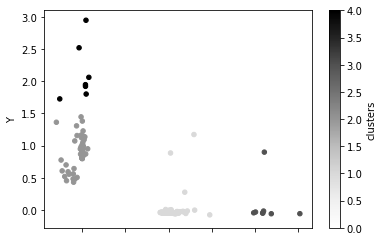

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
#Run the model using highest score values against all records using best k value from sample.
kmeanModel = KMeans(n_clusters=5).fit(pca) 
kClusters = kmeanModel.fit_predict(pca)
 
#add kmeanas clusters to the original dataframe.
pca['clusters'] = kClusters

pca.plot.scatter(x='X', y='Y', c='clusters')
plt.show()

In [17]:
knn.fit(pca, y_train)
train_score = knn.score(pca, y_train)
print("Train: {}".format(train_score))

Train: 0.8005327019828351


In [18]:
clusters = pd.get_dummies(pca['clusters'], drop_first=True)
knn.fit(clusters, y_train)
train_score = knn.score(clusters, y_train)
print("Train: {}".format(train_score))

Train: 0.6771234092926901


Compare your models' performances with those of the example.

In [19]:
#Example Performance 
r = {'type': ['example II', 'example II', 'example II', 'example I', 'example I', 'example I'], 
       'model': ['logistic','random', 'gradient', 'logistic','random', 'gradient'], 
       'test': [ 0.7829560585885486, 0.800266311584554, 0.7616511318242344, 0.8761651131824234, 0.8504216600088771, 0.8362183754993342], 
       'train': [0.9165433560224918, 0.9529446581828943, 0.7664989641905889, 0.9354838709677419, 0.9795797573246523, 0.8514353358981948]}

#store the scores in a results table for comparison.
results = pd.DataFrame(r)
results = results.append(k)
results.set_index(['type', 'model'], inplace=True)


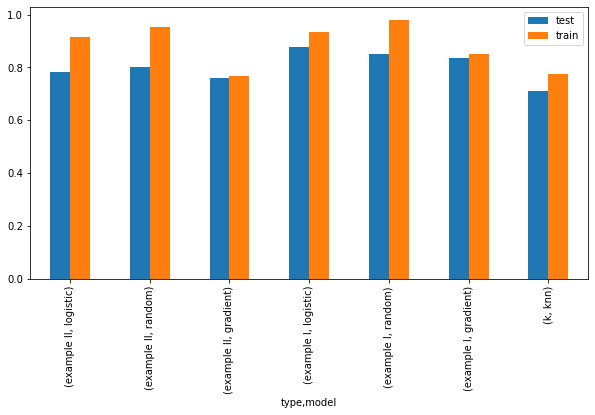

In [20]:
results.plot.bar(figsize=(10,5))
plt.show()

## Part II
In the 2-gram example above, you only used 2-gram as your features. 

This time, use both 1-gram and 2-gram features together as your feature set. 

Run the same models as in the example and compare the results.

In [21]:
# we'll use 2-grams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
X = vectorizer.fit_transform(sentences["text"])
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
sentences = pd.concat([bow_df, sentences[["text", "author"]]], axis=1)
sentences.head()

,1st,29th,29th september,abbreviation,abbreviation living,abdication,abdication neighbour,abide,abide consequence,abide figure,...,zealand australia,zealous,zealous officer,zealous subject,zealously,zealously discharge,zigzag,zigzag go,text,author
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Alice begin tired sit sister bank have twice p...,Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,consider mind hot day feel sleepy stupid pleas...,Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,remarkable Alice think way hear Rabbit,Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,oh dear,Carroll


In [22]:
Y = sentences['author']
X = np.array(sentences.drop(['text','author'], 1))

# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
#Classification Reports
print("----------------------Logistic Regression Scores----------------------")
print(classification_report(y_test, lr.predict(X_test)))
print("----------------------Random Forest Scores----------------------")
print(classification_report(y_test, rfc.predict(X_test)))
print("----------------------Gradient Boosting Scores----------------------")
print(classification_report(y_test, gbc.predict(X_test)))
print("----------------------KNN Boosting Scores----------------------")
print(classification_report(y_test, knn.predict(X_test)))

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.87      0.97      0.91      1537
     Carroll       0.91      0.68      0.78       716

    accuracy                           0.88      2253
   macro avg       0.89      0.82      0.84      2253
weighted avg       0.88      0.88      0.87      2253

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.87      0.93      0.90      1537
     Carroll       0.83      0.71      0.76       716

    accuracy                           0.86      2253
   macro avg       0.85      0.82      0.83      2253
weighted avg       0.86      0.86      0.86      2253

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.82      0.97      0.89      1537
     Carroll       0.90      0.5

In [24]:
#Results Table
t = []
#type indicator for the results dictionary
for i in range(0, 4):
    t.append('two')
#dictionary for these results.
d = {'type': t}


d['model'] = ['logistic']
d['test'] = [lr.score(X_test, y_test)]
d['train'] = [lr.score(X_train, y_train)]


d['model'].append('random')
d['test'].append(rfc.score(X_test, y_test))
d['train'].append(rfc.score(X_train, y_train) )

d['model'].append('gradient')
d['test'].append(gbc.score(X_test, y_test))
d['train'].append(gbc.score(X_train, y_train) )

d['model'].append('knn')
d['test'].append(knn.score(X_test, y_test))
d['train'].append(knn.score(X_train, y_train))


In [31]:
d = pd.DataFrame(d)
d.set_index(['type', 'model'], inplace=True)
d

test     train
type model                       
two  logistic  0.875277  0.955608
     random    0.860186  0.979580
     gradient  0.833555  0.849068
     knn       0.730581  0.809707

In [37]:
new_results = pd.concat([results, d])

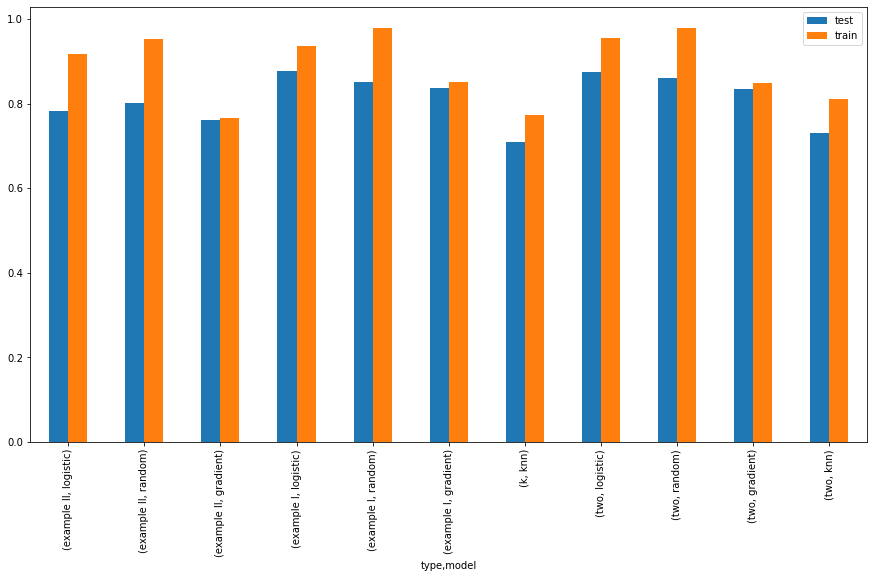

In [39]:
new_results.plot.bar(figsize=(15,8))
plt.show()

Random forest, hands down, takes the cake on this classification example. While not noted - is was observed over several processes (I've run this notebook several times because I'm prone to logistical errors), anyway - it has a pretty fast fit and score time. The model I selected, KNN - has the longest runtime.

The Random forest model gets better scoring results. It has the highest testing scores. When it comes to which example to use - I'd go with the number two example.
